# Aim

Attempting to implement the Support Vector Kalman method, as described at http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.672.2696&rep=rep1&type=pdf.


In [1]:
from sklearn import svm
import numpy as np
from aberrations import make_vibe_params, make_vibe_data, make_noisy_data, measurement_noise, f_1
from observer import make_kfilter, vibe_fit_freq, get_psd, predict, update, noise_filter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from aberrations import time_id, f_sampling, f_1, times
W = 60
N = 10
steps = int(f_sampling * time_id)
times = np.arange(0, time_id, 1 / f_sampling)

In [3]:
# set up state training data
truth = make_vibe_data(N=N)
measurements = make_noisy_data(truth)

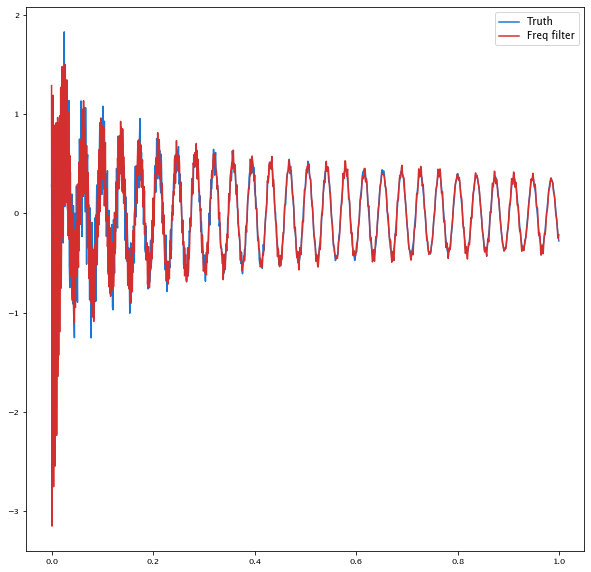

In [4]:
# first, let's run the Kalman filter for half a second normally
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=N))
states_freq = np.zeros((steps, state.size))
for k in range(steps):
    state, P = update(H, P, R, state, measurements[k])
    states_freq[k] = state
    state, P = predict(A, P, Q, state)
    
pos_freq = np.array([H.dot(state) for state in states_freq]).flatten()

plt.figure(figsize=(10,10))
plt.plot(times, truth, label='Truth')
plt.plot(times, pos_freq, label='Freq filter')
plt.legend()

In [5]:
# evolve states based on this A. Note that the SVRs are getting trained but A itself isn't. May add KF for A later.
k = steps//2
state = states_freq[k]
states_svk = np.zeros((steps, state.size))
states_svk[:k] = states_freq[:k]
STATE_SIZE = 2*N
while k < steps:
    # Make the A matrix for a transition from state k to state k + 1. Assumed k > W + 1.
    if k == steps//2:
        x_training = states_svk[k-W-2:k-1] # a row is the state at a specific timestep: size (W+1, state.size)
        y_training = states_svk[k-W-1:k].T # a row is a state variable over the W timesteps: size (state.size, W+1)
        # normalize and rescale
        x_recentering = (np.min(x_training, axis=0) + np.max(x_training, axis=0))/2
        y_recentering = (np.min(y_training, axis=1) + np.max(y_training, axis=1))/2
        x_training -= np.tile(x_recentering, (W+1, 1))
        y_training -= np.repeat(y_recentering, W+1).reshape(state.size,W+1)
        x_scales = (np.max(x_training, axis=0) - np.min(x_training, axis=0))/2
        y_scales = (np.max(y_training, axis=1) - np.min(y_training, axis=1))/2
        x_training /= np.tile(x_scales, (W+1, 1))
        y_training /= np.repeat(y_scales, W+1).reshape(state.size,W+1)
        
        A = np.zeros((STATE_SIZE, STATE_SIZE))
        svk = [svm.SVR(kernel='linear',gamma='scale', C=1, epsilon=0.2)] * N
        for i in range(N):
            # help out the SVK by telling it the only state elements that matter
            # we know this is the case because we ran in frequency mode for half a second
            x_training_i = x_training[:,2*i:2*i+2]
            svk[i].fit(x_training_i, y_training[2*i])
            predictions = np.array([svk[i].predict(np.array([[1, 0]]))[0], 
                                    svk[i].predict(np.array([[0, 1]]))[0]])
            A[2*i][2*i], A[2*i][2*i+1] = predictions * (y_scales/x_scales)[2*i:2*i+2]
            A[2*i+1][2*i] = 1
        print(A)
    state, P = update(H, P, R, state, measurements[k])
    states_svk[k] = state
    state, P = predict(A, P, Q, state)
    k += 1
    
pos_svk = np.array([H.dot(state) for state in states_svk]).flatten()

[[ 1.40116855e+00 -5.05340585e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.32096157e+01 -1.26052836e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   7.79632701e-01 -4.12455856e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

(-1.8280438418930356, 1.8280438418930356)

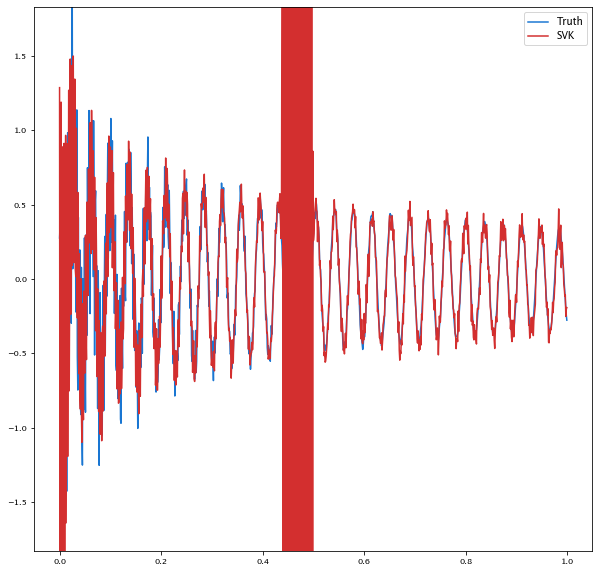

In [6]:
plt.figure(figsize=(10,10))
lim = np.max(np.abs(truth))
plt.plot(times, truth, label='Truth')
plt.plot(times, pos_svk, label='SVK')
plt.legend()
plt.ylim(-lim, lim)

(0, 1)

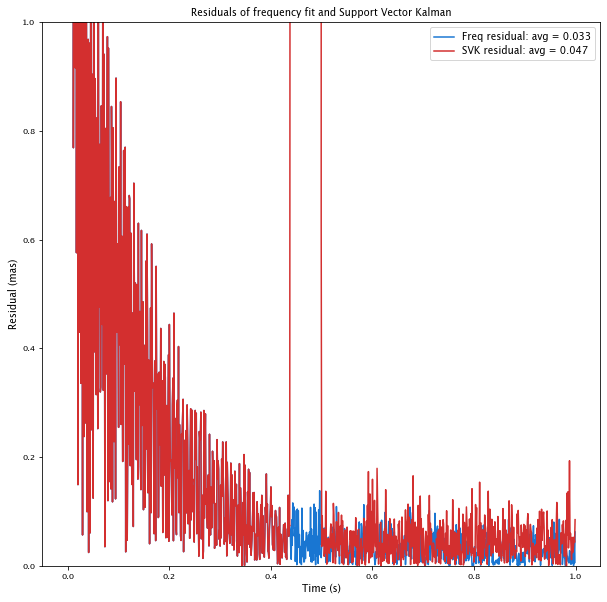

In [14]:
plt.figure(figsize=(10,10))
res_svk = np.abs(pos_svk - truth)
res_freq = np.abs(pos_freq - truth)
plt.plot(times, res_freq, label='Freq residual: avg = ' 
         + str(np.round(np.mean(res_freq[steps//2:]), 3)))
plt.plot(times, res_svk, label='SVK residual: avg = ' 
         + str(np.round(np.mean(res_svk[steps//2:]), 3)))
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Residual (mas)")
plt.title("Residuals of frequency fit and Support Vector Kalman")
plt.ylim(0, 1)